In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import shapely.geometry as shapgeo
from copy import deepcopy

In [2]:
canvas = np.zeros((250,250,3), np.uint8)
gray_canvas = np.zeros((250,250), np.uint8)

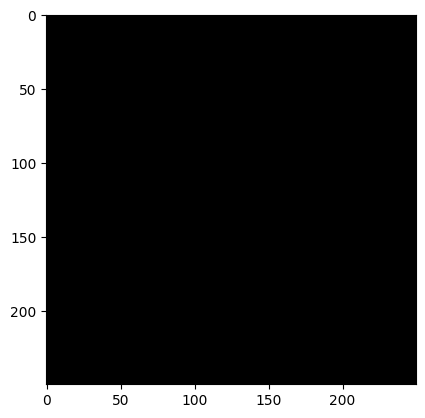

In [5]:
plt.imshow(gray_canvas, 'gray')

In [7]:
optic_disc = cv2.ellipse(deepcopy(gray_canvas),
                        (int(gray_canvas.shape[1]/2), int(gray_canvas.shape[0]/2)),
                        (80,100),
                        0, 0, 360, 255, -1)

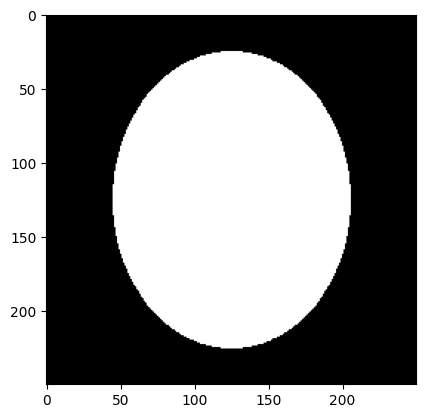

In [9]:
plt.imshow(optic_disc, 'gray')

In [10]:
optic_cup = cv2.circle(deepcopy(gray_canvas),
                      (110, 150),
                      35, 255, -1)

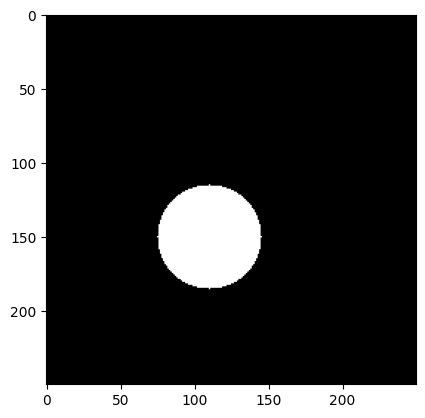

In [12]:
plt.imshow(optic_cup, 'gray')

In [62]:
def get_rdr(od, oc):
    nrr = cv2.subtract(od, oc)
    ret, th = cv2.threshold(nrr, 128, 255, cv2.THRESH_BINARY)
    conts, _ = cv2.findContours(th, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    # cek jika OD dan OC terdeteksi
    if len(conts) != 2:
        print('hell no')
    else:
        # ambil contours
        outer = [cv2.approxPolyDP(conts[0], 0.1, True)]
        inner = [cv2.approxPolyDP(conts[1], 0.1, True)]
        # visualisasi
        h, w = nrr.shape[:2]
        vis = np.zeros((h, w, 3), np.uint8)
        cv2.drawContours(vis, outer, -1, (255, 0, 0), 1)
        cv2.drawContours(vis, inner, -1, (0, 0, 255), 1)
        # Squeeze contours for further processing
        outer = np.vstack(outer).squeeze()
        inner = np.vstack(inner).squeeze()
        # Calculate centroid of inner contour
        M = cv2.moments(inner)
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])

        # Calculate maximum needed radius for later line intersections
        r_max = np.min([cx, w - cx, cy, h - cy])

        # Set up angles (in degrees)
        angles = np.arange(0, 360, 4)

        # Initialize distances
        dists = np.zeros_like(angles)

        # Prepare calculating the intersections using Shapely
        poly_outer = shapgeo.asLineString(outer)
        poly_inner = shapgeo.asLineString(inner)
        
        for i, angle in enumerate(angles):
            # Convert angle from degrees to radians
            angle = angle / 180 * np.pi

            # Calculate end points of line from centroid in angle's direction
            x = np.cos(angle) * r_max + cx
            y = np.sin(angle) * r_max + cy
            points = [(cx, cy), (x, y)]

            # Calculate intersections using Shapely
            poly_line = shapgeo.LineString(points)
            insec_outer = np.array(poly_outer.intersection(poly_line))
            insec_inner = np.array(poly_inner.intersection(poly_line))

            # Calculate distance between intersections using L2 norm
            try:
                dists[i] = np.linalg.norm(insec_outer - insec_inner)
            except ValueError:
                continue

            # Just for visualization purposes: Draw lines for some examples
            if (i == 10) or (i == 40) or (i == 127):

                # Line from centroid to end points
                cv2.line(vis, (cx, cy), (int(x), int(y)), (128, 128, 128), 1)

                # Line between both shapes
                cv2.line(vis,
                         (int(insec_inner[0]), int(insec_inner[1])),
                         (int(insec_outer[0]), int(insec_outer[1])), (0, 255, 0), 2)

                # Distance
                cv2.putText(vis, str(dists[i]), (int(x), int(y)),
                            cv2.FONT_HERSHEY_COMPLEX, 0.75, (0, 255, 0), 2)
        # plt.imshow(vis)
        res = np.vstack([angles, dists]).T
        min_dis = min(dists[dists!=0])
        print(dists[dists!=0])
        print(min_dis)
    return 0

In [63]:
rdr = get_rdr(optic_disc, optic_cup)

/tmp/ipykernel_12010/3309180450.py:1: ShapelyDeprecationWarning: The proxy geometries (through the 'asShape()', 'asLineString()' or 'LineStringAdapter()' constructors) are deprecated and will be removed in Shapely 2.0. Use the 'shape()' function or the standard 'LineString()' constructor instead.
  rdr = get_rdr(optic_disc, optic_cup)
/tmp/ipykernel_12010/3309180450.py:1: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  rdr = get_rdr(optic_disc, optic_cup)


[56 56 54 53 52 52 50 50 49 48 48 48 47 46 46 45 44 43 42 41 40 40 39 37
 36 34 33 31 31 30 28 28 27 26 25 24 24 24 24 24 24 24 24 25 26 26 28 29
 29 32 34 35 38 39 42 45 48 51 55 59 62 63 61 59 58]
24
